In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.models as models
import torch.nn as nn

from collections import Counter
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a fixed size, if needed
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Directories for the datasets
fold_0_dir = '/content/kaggle/input/dataset/training_data/fold_0'
fold_1_dir = '/content/kaggle/input/dataset/training_data/fold_1'
fold_2_dir = '/content/kaggle/input/dataset/training_data/fold_2'

# Load datasets for each fold
fold_0_dataset = datasets.ImageFolder(root=fold_0_dir, transform=transform)
fold_1_dataset = datasets.ImageFolder(root=fold_1_dir, transform=transform)
fold_2_dataset = datasets.ImageFolder(root=fold_2_dir, transform=transform)

# Concatenate datasets from all folds
full_dataset = ConcatDataset([fold_0_dataset, fold_1_dataset, fold_2_dataset])

In [ ]:
import os
print(os.listdir('/content/kaggle/input/'))

['.ipynb_checkpoints', 'C-NMC_Leukemia.zip']


In [ ]:
file_path = '/content/kaggle/input/C-NMC_Leukemia.zip'
print(os.path.getsize(file_path))  # Check if the file size is non-zero

908757628


In [ ]:
!ls /content  # Check the exact file name

kaggle	sample_data


In [ ]:
import zipfile

zip_file_path = '/content/kaggle/input/C-NMC_Leukemia.zip'  # Ensure this is the correct path
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/kaggle/input/dataset')
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("The file is not a valid ZIP file.")

Extraction successful!


In [ ]:
# Define class names (assume fold_0_dataset is loaded before this step)
class_names = fold_0_dataset.classes  # Assuming all folds have the same classes
class_indices = {class_name: [] for class_name in class_names}

# Separate indices by class
for idx, (_, label) in enumerate(full_dataset):
    class_name = class_names[label]
    class_indices[class_name].append(idx)

In [ ]:
def limit_dataset(dataset, max_train_samples=None, max_test_samples=None):
    # Limit the number of train samples for each class
    train_indices = []
    if max_train_samples:
        for class_name, max_samples in max_train_samples.items():
            indices = class_indices[class_name]
            max_samples_per_class = min(max_samples, len(indices))
            selected_indices = random.sample(indices, max_samples_per_class)
            train_indices.extend(selected_indices)

    # Remove train indices from class indices for the test set
    for indices in train_indices:
        class_name = class_names[dataset[indices][1]]
        class_indices[class_name].remove(indices)

    test_indices = []
    if max_test_samples:
        # Randomly select the specified number of test samples from all available indices
        all_test_indices = list(range(len(dataset)))  # Assuming you're selecting from the entire dataset
        test_indices = random.sample(all_test_indices, min(max_test_samples, len(all_test_indices)))


    return train_indices, test_indices

# Define the maximum limits for train and test samples
max_train_samples = {'all': 7000, 'hem': 3000}  # Max samples for 'all' and 'hem' in the train dataset
max_test_samples = 2000  # Max total samples in the test dataset

# Limit the dataset
train_indices, test_indices = limit_dataset(full_dataset, max_train_samples=max_train_samples, max_test_samples=max_test_samples)

# Create subsets for train and test
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Number of data points in train loader: 10000
Number of data points in test loader: 2000


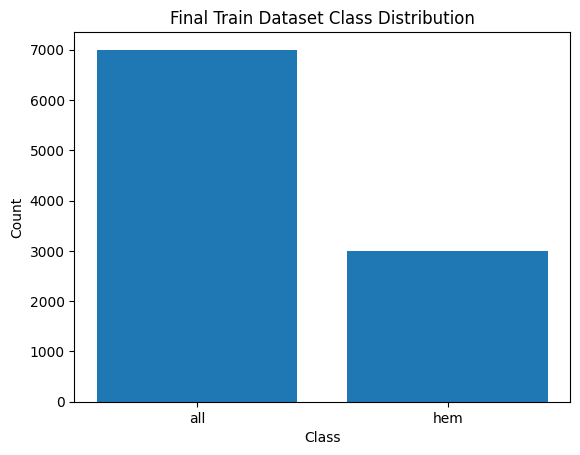

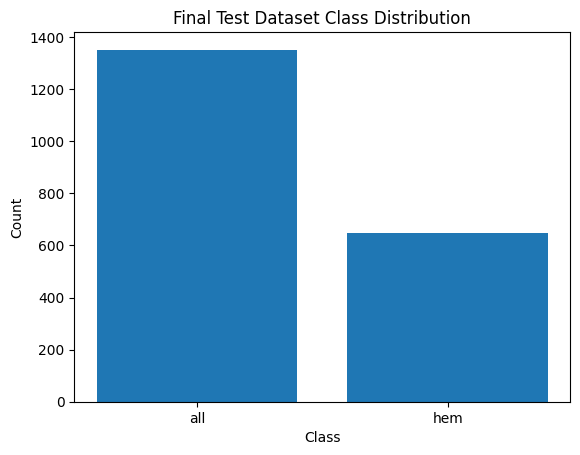

In [ ]:
# Data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print the number of data points in train and test loaders
print(f"Number of data points in train loader: {len(train_dataset)}")
print(f"Number of data points in test loader: {len(test_dataset)}")

# Function to get class distribution for a dataset
def get_class_distribution(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

# Get class distribution for train and test datasets
train_class_distribution = get_class_distribution(train_dataset)
test_class_distribution = get_class_distribution(test_dataset)

# Plotting function
def plot_class_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(classes, [class_names[i] for i in classes])
    plt.show()

# Plot class distributions
plot_class_distribution(train_class_distribution, "Final Train Dataset Class Distribution")
plot_class_distribution(test_class_distribution, "Final Test Dataset Class Distribution")

In [ ]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    torch.nn.Linear(num_ftrs, 4),
    torch.nn.Linear(4, 2),
)  # Assuming binary classification

model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
Freeze = False
if Freeze:
    # Freeze the base model
    for param in model.parameters():
        param.requires_grad = False

    # Only train the last fully connected layer
    for param in model.fc.parameters():
        param.requires_grad = True

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Determine the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [ ]:
# num_epochs = 64
num_epochs = 5
best_loss = 1000

for epoch in range(num_epochs):
    model.to(device)  # Move the model to the device
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct / total
    train_accs.append(train_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}%')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move the data to the device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total
    val_accs.append(val_acc)

    if val_loss < best_loss:
        print("Saving model...")
        torch.save(model.state_dict(), 'model.pth')
        best_loss = val_loss

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}%')
torch.save(model.state_dict(), 'model_last.pth')

Epoch 1/5 (Training):   0%|          | 0/313 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5 (Training): 100%|██████████| 313/313 [00:50<00:00,  6.23batch/s]


Epoch 1/5, Training Loss: 0.29664601451053785, Training Accuracy: 88.11%


Epoch 1/5 (Validation): 100%|██████████| 63/63 [00:10<00:00,  6.03batch/s]


Saving model...
Epoch 1/5, Validation Loss: 0.23653218966154826, Validation Accuracy: 90.6%


Epoch 2/5 (Training): 100%|██████████| 313/313 [00:50<00:00,  6.26batch/s]


Epoch 2/5, Training Loss: 0.1867935980399386, Training Accuracy: 92.97%


Epoch 2/5 (Validation): 100%|██████████| 63/63 [00:07<00:00,  8.22batch/s]


Epoch 2/5, Validation Loss: 0.3487692851395834, Validation Accuracy: 85.0%


Epoch 3/5 (Training): 100%|██████████| 313/313 [00:52<00:00,  5.97batch/s]


Epoch 3/5, Training Loss: 0.13497422466548487, Training Accuracy: 95.13%


Epoch 3/5 (Validation): 100%|██████████| 63/63 [00:10<00:00,  5.82batch/s]


Saving model...
Epoch 3/5, Validation Loss: 0.10110245260690885, Validation Accuracy: 96.6%


Epoch 4/5 (Training): 100%|██████████| 313/313 [00:50<00:00,  6.18batch/s]


Epoch 4/5, Training Loss: 0.09300547686462014, Training Accuracy: 96.29%


Epoch 4/5 (Validation): 100%|██████████| 63/63 [00:07<00:00,  8.37batch/s]


Epoch 4/5, Validation Loss: 0.31601484226328985, Validation Accuracy: 88.45%


Epoch 5/5 (Training): 100%|██████████| 313/313 [00:50<00:00,  6.26batch/s]


Epoch 5/5, Training Loss: 0.07325766747222302, Training Accuracy: 97.47%


Epoch 5/5 (Validation): 100%|██████████| 63/63 [00:10<00:00,  5.86batch/s]


Saving model...
Epoch 5/5, Validation Loss: 0.07502777260609918, Validation Accuracy: 97.2%


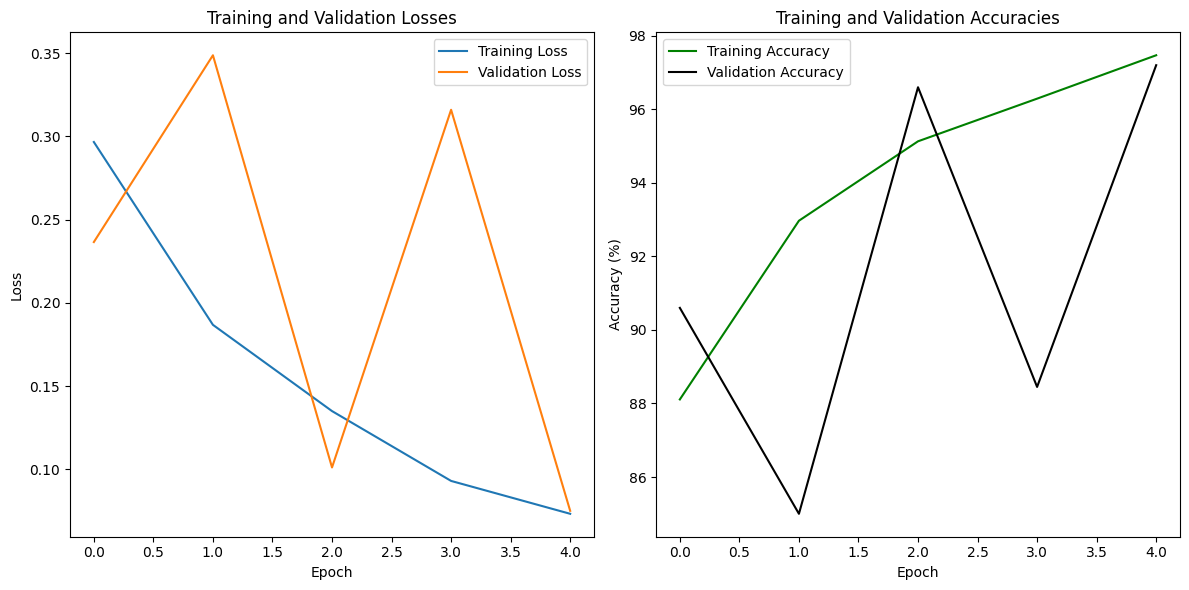

In [ ]:
## Plotting the Losses and Accuracies
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
# Load the saved model weights
model_path = '/content/model.pth'
model.load_state_dict(torch.load(model_path))

<ipython-input-22-4bff14a1e657>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import time

# Set the model to evaluation mode
model.eval()

# Initialize variables for metrics
correct = 0
total = 0
all_labels = []
all_predictions = []

# Start time
start_time = time.time()

# No gradient calculation needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:  # Use test_loader for evaluation
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data.to('cpu'), 1)

        # Update correct and total counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect all labels and predictions for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# End time
end_time = time.time()
computational_time = end_time - start_time

# Accuracy
accuracy = 100 * correct / total

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# For multi-class classification, handle the confusion matrix appropriately
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# For binary classification, get true positives, false positives, etc.
if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()  # Confusion matrix for binary classification
    sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
    specificity = tn / (tn + fp)  # True Negative Rate
else:
    # For multi-class classification, you might need to calculate metrics differently
    sensitivity = None
    specificity = None

# Error Rate
error_rate = 1 - accuracy / 100

# Print Metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
if sensitivity is not None and specificity is not None:
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
print(f'Error Rate: {error_rate}')
print(f'Computational Time: {computational_time:.2f} seconds')

Confusion Matrix:
[[1330   21]
 [  35  614]]
Accuracy: 97.2%
Precision: 0.9719479911164951
Recall: 0.972
F1 Score: 0.9719195169733758
Sensitivity: 0.9460708782742681
Specificity: 0.9844559585492227
Error Rate: 0.028000000000000025
Computational Time: 13.66 seconds
